In [20]:
# from sklearn.datasets import make_multilabel_classification
from torch.utils.data import Dataset
import json
import numpy as np
import torch
import time
from tqdm import tqdm

from preprocessing import for_train

In [21]:
# X, y = for_train("coauthor", p=-1)
X, y = for_train("coauthor", p=0.20250)

delet some useless data: 100%|██████████| 25793/25793 [00:01<00:00, 24362.18it/s]


Number of instance with label :  7460
Number of instance without label(remain) :  1894


authors: 100%|██████████| 25793/25793 [00:03<00:00, 7422.64it/s] 


In [22]:
print(X.shape)

N_FEATURES = X.shape[1]

torch.Size([9354, 21146])


In [24]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

X_train = X
X_test = X
y_train = y
y_test = y

print("Train:")
print("     X_train : ", X_train.shape)
print("     y_train : ", y_train.shape)
print("Test_Kaggle:")
print("     X_test  : ", X_test.shape)
print("     y_test  : ", y_test.shape)


Train:
     X_train :  torch.Size([9354, 21146])
     y_train :  torch.Size([9354, 100])
Test_Kaggle:
     X_test  :  torch.Size([9354, 21146])
     y_test  :  torch.Size([9354, 100])


In [25]:
from NN_Models import *

In [26]:
print(f"[INFO]: Number of training samples: {X_train.shape[0]}")
print(f"[INFO]: Number of training features: {X_train.shape[1]}")

# train data loader
train_dataset, train_dataloader = BinaryDataLoader(X_train, y_train, shuffle=True, batch_size=100)

# initialize the model
model = NeuralNetworkCoauthor()

[INFO]: Number of training samples: 9354
[INFO]: Number of training features: 21146


In [27]:
import torch.optim as optim

# learning parameters
optimizer = optim.Adam(params=model.parameters(), lr=0.001) # 学习率衰减 / 学习率震荡
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100

# load the model on to the computation device
model.to(device)

NeuralNetworkCoauthor(
  (fc1): Linear(in_features=21146, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=100, bias=True)
)

In [28]:
import torch

# start the training
start = time.time()
train_loss = []
for epoch in tqdm(range(epochs)):
    # print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, train_dataloader, optimizer, loss_fn, train_dataset, device
    )
    train_loss.append(train_epoch_loss)
    # print(f"Train Loss: {train_epoch_loss:.4f}")
torch.save(model.state_dict(), 'status/model_authors.pth')

print("="*25)
print(time.time()-start, 's')

Epoch 1 of 100


94it [00:54,  1.72it/s]                        


Train Loss: 0.1666
Epoch 2 of 100


94it [00:53,  1.77it/s]                        


Train Loss: 0.0595
Epoch 3 of 100


94it [00:42,  2.19it/s]                        


Train Loss: 0.0538
Epoch 4 of 100


94it [00:48,  1.93it/s]                        


Train Loss: 0.0516
Epoch 5 of 100


94it [00:43,  2.14it/s]                        


Train Loss: 0.0461
Epoch 6 of 100


94it [00:40,  2.34it/s]                        


Train Loss: 0.0361
Epoch 7 of 100


94it [00:44,  2.13it/s]                        


Train Loss: 0.0222
Epoch 8 of 100


94it [00:44,  2.10it/s]                        


Train Loss: 0.0135
Epoch 9 of 100


94it [00:51,  1.84it/s]                        


Train Loss: 0.0097
Epoch 10 of 100


94it [00:47,  1.98it/s]                        


Train Loss: 0.0079
Epoch 11 of 100


94it [00:47,  1.97it/s]                        


Train Loss: 0.0069
Epoch 12 of 100


94it [00:48,  1.95it/s]                        


Train Loss: 0.0062
Epoch 13 of 100


94it [00:50,  1.87it/s]                        


Train Loss: 0.0058
Epoch 14 of 100


94it [00:45,  2.08it/s]                        


Train Loss: 0.0056
Epoch 15 of 100


94it [00:44,  2.12it/s]                        


Train Loss: 0.0054
Epoch 16 of 100


94it [00:44,  2.11it/s]                        


Train Loss: 0.0053
Epoch 17 of 100


94it [00:43,  2.15it/s]                        


Train Loss: 0.0051
Epoch 18 of 100


94it [00:43,  2.17it/s]                        


Train Loss: 0.0051
Epoch 19 of 100


94it [00:43,  2.16it/s]                        


Train Loss: 0.0050
Epoch 20 of 100


94it [00:43,  2.17it/s]                        


Train Loss: 0.0050
Epoch 21 of 100


94it [00:43,  2.17it/s]                        


Train Loss: 0.0049
Epoch 22 of 100


94it [00:43,  2.17it/s]                        


Train Loss: 0.0049
Epoch 23 of 100


94it [00:43,  2.16it/s]                        


Train Loss: 0.0048
Epoch 24 of 100


94it [00:43,  2.17it/s]                        


Train Loss: 0.0048
Epoch 25 of 100


94it [00:43,  2.14it/s]                        


Train Loss: 0.0048
Epoch 26 of 100


94it [00:43,  2.16it/s]                        


Train Loss: 0.0047
Epoch 27 of 100


94it [00:43,  2.14it/s]                        


Train Loss: 0.0047
Epoch 28 of 100


94it [00:43,  2.17it/s]                        


Train Loss: 0.0047
Epoch 29 of 100


94it [00:43,  2.16it/s]                        


Train Loss: 0.0047
Epoch 30 of 100


94it [00:43,  2.14it/s]                        


Train Loss: 0.0047
Epoch 31 of 100


94it [00:43,  2.15it/s]                        


Train Loss: 0.0047
Epoch 32 of 100


94it [00:43,  2.17it/s]                        


Train Loss: 0.0047
Epoch 33 of 100


94it [00:43,  2.14it/s]                        


Train Loss: 0.0046
Epoch 34 of 100


94it [00:43,  2.14it/s]                        


Train Loss: 0.0046
Epoch 35 of 100


94it [00:43,  2.16it/s]                        


Train Loss: 0.0046
Epoch 36 of 100


94it [00:43,  2.16it/s]                        


Train Loss: 0.0046
Epoch 37 of 100


94it [00:43,  2.16it/s]                        


Train Loss: 0.0046
Epoch 38 of 100


94it [00:43,  2.14it/s]                        


Train Loss: 0.0046
Epoch 39 of 100


94it [00:43,  2.16it/s]                        


Train Loss: 0.0046
Epoch 40 of 100


94it [00:43,  2.16it/s]                        


Train Loss: 0.0045
Epoch 41 of 100


94it [00:43,  2.16it/s]                        


Train Loss: 0.0045
Epoch 42 of 100


94it [00:43,  2.16it/s]                        


Train Loss: 0.0045
Epoch 43 of 100


94it [00:43,  2.14it/s]                        


Train Loss: 0.0045
Epoch 44 of 100


94it [00:43,  2.15it/s]                        


Train Loss: 0.0045
Epoch 45 of 100


94it [00:43,  2.14it/s]                        


Train Loss: 0.0045
Epoch 46 of 100


94it [00:44,  2.10it/s]                        


Train Loss: 0.0045
Epoch 47 of 100


94it [00:46,  2.02it/s]                        


Train Loss: 0.0045
Epoch 48 of 100


94it [00:44,  2.14it/s]                        


Train Loss: 0.0045
Epoch 49 of 100


94it [00:43,  2.14it/s]                        


Train Loss: 0.0045
Epoch 50 of 100


94it [00:43,  2.15it/s]                        


Train Loss: 0.0045
Epoch 51 of 100


94it [00:43,  2.15it/s]                        


Train Loss: 0.0045
Epoch 52 of 100


94it [00:43,  2.14it/s]                        


Train Loss: 0.0044
Epoch 53 of 100


94it [00:43,  2.14it/s]                        


Train Loss: 0.0045
Epoch 54 of 100


94it [00:43,  2.16it/s]                        


Train Loss: 0.0044
Epoch 55 of 100


94it [00:43,  2.14it/s]                        


Train Loss: 0.0044
Epoch 56 of 100


94it [00:43,  2.15it/s]                        


Train Loss: 0.0045
Epoch 57 of 100


94it [00:43,  2.14it/s]                        


Train Loss: 0.0044
Epoch 58 of 100


94it [00:44,  2.11it/s]                        


Train Loss: 0.0044
Epoch 59 of 100


94it [00:44,  2.13it/s]                        


Train Loss: 0.0044
Epoch 60 of 100


94it [00:44,  2.13it/s]                        


Train Loss: 0.0044
Epoch 61 of 100


94it [00:44,  2.13it/s]                        


Train Loss: 0.0044
Epoch 62 of 100


94it [00:43,  2.14it/s]                        


Train Loss: 0.0044
Epoch 63 of 100


94it [00:44,  2.13it/s]                        


Train Loss: 0.0044
Epoch 64 of 100


94it [00:44,  2.10it/s]                        


Train Loss: 0.0043
Epoch 65 of 100


94it [00:44,  2.10it/s]                        


Train Loss: 0.0044
Epoch 66 of 100


94it [00:44,  2.13it/s]                        


Train Loss: 0.0043
Epoch 67 of 100


94it [00:44,  2.12it/s]                        


Train Loss: 0.0044
Epoch 68 of 100


94it [00:44,  2.11it/s]                        


Train Loss: 0.0044
Epoch 69 of 100


94it [00:44,  2.12it/s]                        


Train Loss: 0.0043
Epoch 70 of 100


94it [00:44,  2.10it/s]                        


Train Loss: 0.0043
Epoch 71 of 100


94it [00:44,  2.12it/s]                        


Train Loss: 0.0043
Epoch 72 of 100


94it [00:44,  2.13it/s]                        


Train Loss: 0.0043
Epoch 73 of 100


94it [00:44,  2.11it/s]                        


Train Loss: 0.0043
Epoch 74 of 100


94it [00:44,  2.11it/s]                        


Train Loss: 0.0043
Epoch 75 of 100


94it [00:44,  2.11it/s]                        


Train Loss: 0.0043
Epoch 76 of 100


94it [00:44,  2.12it/s]                        


Train Loss: 0.0043
Epoch 77 of 100


94it [00:44,  2.09it/s]                        


Train Loss: 0.0043
Epoch 78 of 100


94it [00:45,  2.07it/s]                        


Train Loss: 0.0043
Epoch 79 of 100


94it [00:44,  2.09it/s]                        


Train Loss: 0.0043
Epoch 80 of 100


94it [00:44,  2.10it/s]                        


Train Loss: 0.0043
Epoch 81 of 100


94it [00:44,  2.10it/s]                        


Train Loss: 0.0043
Epoch 82 of 100


94it [00:44,  2.11it/s]                        


Train Loss: 0.0043
Epoch 83 of 100


94it [00:44,  2.10it/s]                        


Train Loss: 0.0043
Epoch 84 of 100


94it [00:44,  2.10it/s]                        


Train Loss: 0.0043
Epoch 85 of 100


94it [00:45,  2.08it/s]                        


Train Loss: 0.0043
Epoch 86 of 100


94it [00:45,  2.07it/s]                        


Train Loss: 0.0043
Epoch 87 of 100


94it [00:45,  2.07it/s]                        


Train Loss: 0.0043
Epoch 88 of 100


94it [00:48,  1.94it/s]                        


Train Loss: 0.0046
Epoch 89 of 100


94it [31:15, 19.95s/it]                           


Train Loss: 0.0044
Epoch 90 of 100


94it [25:55, 16.55s/it]                           


Train Loss: 0.0050
Epoch 91 of 100


94it [00:59,  1.59it/s]                        


Train Loss: 0.0044
Epoch 92 of 100


94it [00:56,  1.65it/s]                        


Train Loss: 0.0043
Epoch 93 of 100


94it [00:52,  1.80it/s]                        


Train Loss: 0.0045
Epoch 94 of 100


94it [00:52,  1.80it/s]                        


Train Loss: 0.0044
Epoch 95 of 100


94it [00:51,  1.83it/s]                        


Train Loss: 0.0046
Epoch 96 of 100


94it [00:51,  1.81it/s]                        


Train Loss: 0.0045
Epoch 97 of 100


94it [00:50,  1.85it/s]                        


Train Loss: 0.0044
Epoch 98 of 100


94it [00:50,  1.87it/s]                        


Train Loss: 0.0044
Epoch 99 of 100


94it [00:51,  1.81it/s]                        


Train Loss: 0.0044
Epoch 100 of 100


94it [00:52,  1.78it/s]                        


Train Loss: 0.0044
7893.5981612205505 s


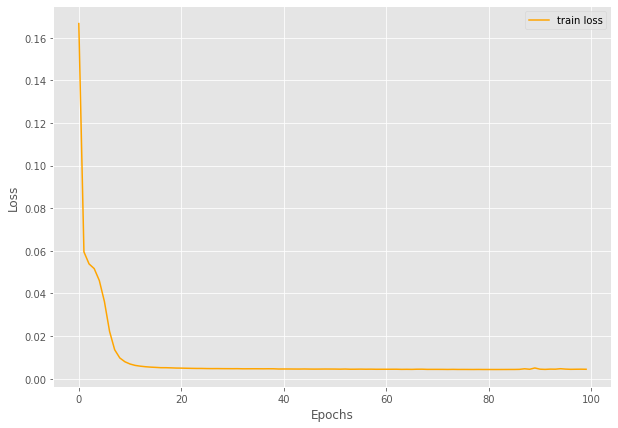

In [29]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

# plot and save the train loss graph
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('outputs/multi_head_binary_loss.png')
plt.show()

### Test (ignore when submit kaggle)

In [30]:
# print some info
print(f"[INFO]: Number of testing samples: {X_test.shape[0]}")
print(f"[INFO]: Number of testing features: {X_test.shape[1]}")

# train data loader
test_dataset, test_dataloader = BinaryDataLoader(X_test, y_test, shuffle=False, batch_size=1)

[INFO]: Number of testing samples: 9354
[INFO]: Number of testing features: 21146


In [31]:
model = NeuralNetworkCoauthor()
model.load_state_dict(torch.load('status/model_authors.pth'))
model.to(device)
model.eval()

NeuralNetworkCoauthor(
  (fc1): Linear(in_features=21146, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=100, bias=True)
)

In [32]:
from preprocessing import *

target_list = transform_labels(y_test, threshold=1)

In [33]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

def get_f1(threshold):
    predict_list = []

    for i, test_sample in enumerate(test_dataloader):
        
        features = test_sample['features']
        
        
        features = torch.reshape(features, (features.shape[0], 1, features.shape[1])).to(device)
        
        outputs = model(features)
        
        outputs = outputs.squeeze()
                
        # get all the labels
        predict_list.append(transform_to_label(outputs, threshold=threshold))

    return predict_list, f1_score(target_list, predict_list, average='weighted')

In [34]:
thresholds = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
f1_scores = []

for i in tqdm(range(len(thresholds))):
    threshold = thresholds[i]

    predict_list, f1 = get_f1(threshold)

    f1_scores.append(f1)

100%|██████████| 9/9 [09:58<00:00, 66.46s/it]


In [35]:
THRESHOLD = thresholds[f1_scores.index(max(f1_scores))]
THRESHOLD

0.05

In [36]:
# max(f1_scores)
f1_scores

[0.9165583890052206,
 0.918875207789176,
 0.9200343843910858,
 0.9029348832043376,
 0.9070402484592045,
 0.9109822419513187,
 0.9120190229962409,
 0.9108447631597559,
 0.9059869036248919]

# Kaggle Predictions

In [38]:
from preprocessing import for_kaggle

X_kaggle = for_kaggle('coauthor')

# print some info
print(f"[INFO]: Number of testing samples: {X_kaggle.shape[0]}")
print(f"[INFO]: Number of testing features: {X_kaggle.shape[1]}")

# train data loader
kaggle_dataloader = BinaryDataLoader(X_kaggle, None, shuffle=False, batch_size=1)

predict_dict = {}

# for i, test_sample in tqdm(enumerate(kaggle_dataloader), total=len(kaggle_dataloader)):
key = 0
for test_sample in tqdm(X_kaggle):
    # print(f"SAMPLE {i}")
    # extract the features and labels
    features = test_sample
    
    outputs = model(features)
    outputs = outputs.squeeze()
    tmp = {}
    
    for i in range(100):
        tmp[i] = outputs[i].item()
         
    predict_dict[key] = tmp
    
    key += 1

# with open('outputs/author.json', 'w') as fp:
#     json.dump(predict_dict, fp)

with open('outputs/author_all.json', 'w') as fp:
    json.dump(predict_dict, fp)

authors: 100%|██████████| 800/800 [00:00<00:00, 8964.20it/s]


[INFO]: Number of testing samples: 800
[INFO]: Number of testing features: 21146


100%|██████████| 800/800 [00:05<00:00, 152.60it/s]
